In [1]:
import datetime
import numpy as np
import pandas as pd
import os
import sys
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append("..")

This notebook runs many simulations, changing the stock allocation (leverage), interest rate cutoff for leveraging, and the interest rate adder (to assume interest rates are higher in the futures).

In [6]:
import lc_investing.constant_percent_stock
lc_investing.constant_percent_stock = reload(lc_investing.constant_percent_stock)

summary_list = []
for labmdacons in [1.00, 1.25, 1.5, 1.75, 2.00]:
  for rate in [1.00, 1.02, 1.04, 1.06, 1.08, 1.1, 1.12, 3.00]:
    r = round(rate, 2)
    for marg_adj in [0.0, 0.02, 0.04, 0.06, 0.08]:
      for borr_rate in [None]: #[1.02, 1.04, 1.06, 1.08]:
        s2 = lc_investing.constant_percent_stock.Simulation(#data_folder='/content/drive/Othercomputers/My MacBook Air/Taxes_and_other_forms/lifecycle_investing/lc_investing/data/',
                                                            data_folder='..\\lc_investing\\data\\',
                                                            bondadj=0,
                                                            margadj=marg_adj,
                                                            stockadj=0,
                                                            lambdacons=labmdacons, # stock allocation
                                                            start_age=30,
                                                            start_amt=1,
                                                            max_rate = r,
                                                            borrowing_rate_override=borr_rate)
        df1 = s2.retirement_savings_before_period.Final.describe([i/10 for i in range(0,10)]).to_frame().reset_index()
        df1.loc[:, 'max_rate'] = r
        df1.loc[:, 'margadj'] = marg_adj
        df1.loc[:, 'borr_rate'] = borr_rate
        df1.loc[:, 'labmdacons']=labmdacons
        df1.loc[:, 'avg_borr_rate'] = s2.monthly_data.Monthly_real_margin_rate.mean()
        df1.loc[:, 'avg_stock_ret'] = s2.monthly_data.Monthly_real_stock_rate.mean()
        # print(r, '\n', s2.retirement_savings_before_period.Final.describe())
        summary_list.append(df1)

df2 = pd.concat(summary_list)
df2.shape

(3000, 8)

In [ ]:
df2.to_csv('/content/drive/Othercomputers/My MacBook Air/Taxes_and_other_forms/lifecycle_investing/grid_search.csv', index=False)

  index     Final  max_rate  margadj borr_rate  labmdacons  avg_borr_rate  \
2   std  6.290406       3.0      0.0      None         1.0       0.002196   
4    0%  4.069389       3.0      0.0      None         1.0       0.002196   

   avg_stock_ret  
2       0.006071  
4       0.006071  


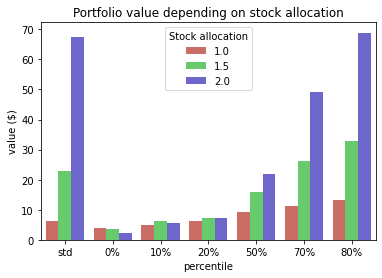

In [7]:
# Using historical margin rates as the borrowing rate, with 
# no interest rate cutoff, what is the effect of leveraging?

df3=df2.loc[~(df2['index'].isin(['count','mean','max', 'min', '30%', '40%', '60%', '90%'])) & \
        (df2['max_rate']==3) & \
        (df2['margadj']==0.00) & \
        # (df2['borr_rate']==1.04) & \
        (df2['labmdacons'].isin([1,1.5,2]))
        ]
b = sns.barplot(data=df3, 
            x="index", 
            y="Final", 
            palette = 'hls', 
            hue="labmdacons").set(title='Portfolio value depending on stock allocation', 
                                  xlabel='percentile', 
                                  ylabel='value ($)');
# leg = b._legend
# leg.set_title("hi")
plt.legend(title='Stock allocation')
print(df3.head(2))

plt.savefig('portfolio_value.png')

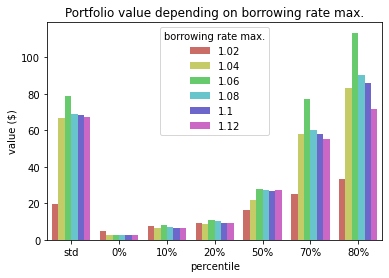

In [8]:
# Impose a rule where you leverage only if the borrowing rate
# is below certain values. Will that improve performance?

df3=df2.loc[~(df2['index'].isin(['count','mean','max', 'min', '30%', '40%', '60%', '90%'])) & \
        (~df2['max_rate'].isin([1,3])) & \
        (df2['margadj']==0.00) & \
        # (df2['borr_rate']==1.04) & \
        (df2['labmdacons'].isin([2]))
        ]
b = sns.barplot(data=df3, 
            x="index", 
            y="Final", 
            palette = 'hls', 
            hue="max_rate").set(title='Portfolio value depending on borrowing rate max.', 
                                  xlabel='percentile', 
                                  ylabel='value ($)');
# leg = b._legend
# leg.set_title("hi")
plt.legend(title='borrowing rate max.')

plt.savefig('portfolio_value_borrowing_max.png')

  index     Final  max_rate  margadj borr_rate  labmdacons  avg_borr_rate  \
2   std  6.290406       3.0     0.04      None         1.0       0.005336   
4    0%  4.069389       3.0     0.04      None         1.0       0.005336   

   avg_stock_ret  
2       0.006071  
4       0.006071  


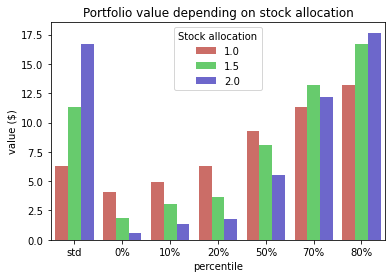

In [9]:
# Suppose interest rates rise a lot above historical levels - by 4% across the board.
# Will leveraging still help?

df3=df2.loc[~(df2['index'].isin(['count','mean','max', 'min', '30%', '40%', '60%', '90%'])) & \
        (df2['max_rate']==3) & \
        (df2['margadj']==0.04) & \
        (df2['labmdacons'].isin([1,1.5,2]))
        ]
b = sns.barplot(data=df3, 
            x="index", 
            y="Final", 
            palette = 'hls', 
            hue="labmdacons").set(title='Portfolio value depending on stock allocation', 
                                  xlabel='percentile', 
                                  ylabel='value ($)');
# leg = b._legend
# leg.set_title("hi")
plt.legend(title='Stock allocation')

print(df3.head(2))

plt.savefig('portfolio_value_margadj4.png')

1.0659396214603751


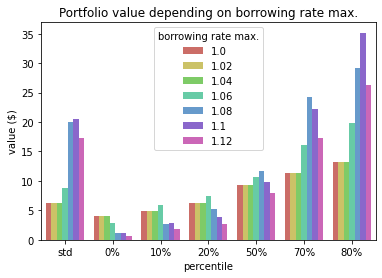

In [10]:
# Suppose interest rates are 4% above their historical levels,
# but we leverage only if we can borrow below certain levels.
# What interest rate cutoff would give the best performance?

df3=df2.loc[~(df2['index'].isin(['count','mean','max', 'min', '30%', '40%', '60%', '90%'])) & \
        (~df2['max_rate'].isin([3])) & \
        (df2['margadj']==0.04) & \
        (df2['labmdacons'].isin([2]))
        ]
b = sns.barplot(data=df3, 
            x="index", 
            y="Final", 
            palette = 'hls', 
            hue="max_rate").set(title='Portfolio value depending on borrowing rate max.', 
                                  xlabel='percentile', 
                                  ylabel='value ($)');
# leg = b._legend
# leg.set_title("hi")
plt.legend(title='borrowing rate max.')

print((df3.head(1).loc[:,'avg_borr_rate'].values[0] + 1)**12)

plt.savefig('portfolio_value_borrowing_max_margadj4.png')

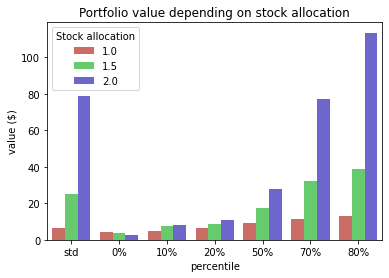

In [11]:
# Choose to leverage only if the borrowing rate is
# is below 6%. Assume we use historical margin 
# rates. What is the effect of leveraging on 
# performance?


df3=df2.loc[~(df2['index'].isin(['count','mean','max', 'min', '30%', '40%', '60%', '90%'])) & \
        (df2['max_rate']==1.06) & \
        (df2['margadj']==0.00) & \
        (df2['labmdacons'].isin([1,1.5,2]))
        ]
b = sns.barplot(data=df3, 
            x="index", 
            y="Final", 
            palette = 'hls', 
            hue="labmdacons").set(title='Portfolio value depending on stock allocation', 
                                  xlabel='percentile', 
                                  ylabel='value ($)');
# leg = b._legend
# leg.set_title("hi")
plt.legend(title='Stock allocation')

plt.savefig('portfolio_value_max_rate6.png')

In [12]:
s2.monthly_data.Annualized_adjusted_margin_rate.mean()

1.1290970027453087

In [2]:
import lc_investing.constant_percent_stock
lc_investing.constant_percent_stock = reload(lc_investing.constant_percent_stock)

# unlevered strategy
s1 = lc_investing.constant_percent_stock.Simulation(#data_folder='/content/drive/Othercomputers/My MacBook Air/Taxes_and_other_forms/lifecycle_investing/lc_investing/data/',
                                                    data_folder='..\\lc_investing\\data\\',
                                                    bondadj=0,
                                                    margadj=0,
                                                    stockadj=0,
                                                    lambdacons=1, # stock allocation
                                                    start_age=30,
                                                    start_amt=1,
                                                    max_rate = 1.06,
                                                    borrowing_rate_override=None)

# unlevered strategy
s2 = lc_investing.constant_percent_stock.Simulation(#data_folder='/content/drive/Othercomputers/My MacBook Air/Taxes_and_other_forms/lifecycle_investing/lc_investing/data/',
                                                    data_folder='..\\lc_investing\\data\\',
                                                    bondadj=0,
                                                    margadj=0,
                                                    stockadj=0,
                                                    lambdacons=2, # stock allocation
                                                    start_age=30,
                                                    start_amt=1,
                                                    max_rate = 1.06,
                                                    borrowing_rate_override=None)

In [3]:
# combine levered and unlevered strategies in one dataframe

df1 = s1.retirement_savings_before_period. \
    drop(columns=['begins_work', 'retire']). \
    rename(columns={'Final': 529})
df1.loc[:, 'lambdacons'] = 1

df1a = df1.melt(id_vars=['cohort_num', 'lambdacons'], 
                value_vars=None, 
                var_name=None, 
                value_name='value')

df2 = s2.retirement_savings_before_period. \
    drop(columns=['begins_work', 'retire']). \
    rename(columns={'Final':529})
df2.loc[:, 'lambdacons'] = 2

df2a = df2.melt(id_vars=['cohort_num', 'lambdacons'], 
                value_vars=None, 
                var_name=None, 
                value_name='value')

df3 = pd.concat([df1a, df2a])

df3.head(2)

,cohort_num,lambdacons,period_num,value
0,1,1,1,0.0
1,2,1,1,0.0


In [4]:
def compare_strategies(df: pd.DataFrame, cohort_num):
    
    df3 = df.copy()
    
    df4 = df3.loc[(df3.cohort_num.isin([cohort_num]))]

    df5 = df4.pivot(index=['cohort_num', 'period_num'], 
                    columns=['lambdacons'], 
                    values=None)

    df5.columns = df5.columns.droplevel(0)
    df5.index = df5.index.droplevel(0)
    
    df5.loc[:, 'diff'] = df5.loc[:, 2] / df5.loc[:, 1]
    
    plt.rcParams['figure.figsize'] = (15, 4)
#     plt.figure(figsize=[5, 3])
#     df5.plot()
#     plt.title('PnL - cohort ' + str(cohort));
    
    fig, axs = plt.subplots(1, 2)
    fig.suptitle('Cohort' + str(cohort))
    axs[0].plot(df5.index, df5.loc[:,1])
    axs[0].plot(df5.index, df5.loc[:,2])
    axs[0].set_title('PnL')
    axs[0].legend('12')
    
    axs[1].plot(df5.index, df5.loc[:,'diff'])
    axs[1].set_title('Levered / unlevered')

C:\Users\Emile\AppData\Local\Temp/ipykernel_13064/2057578342.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 2)


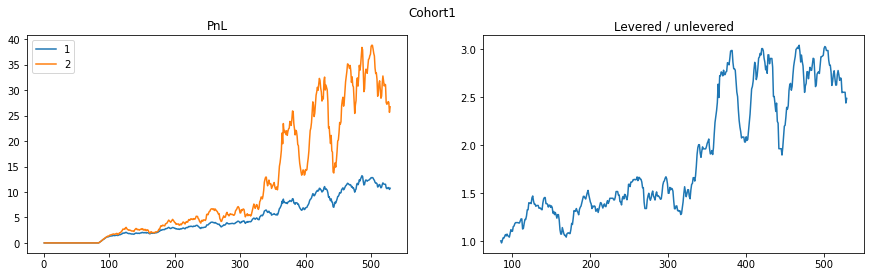

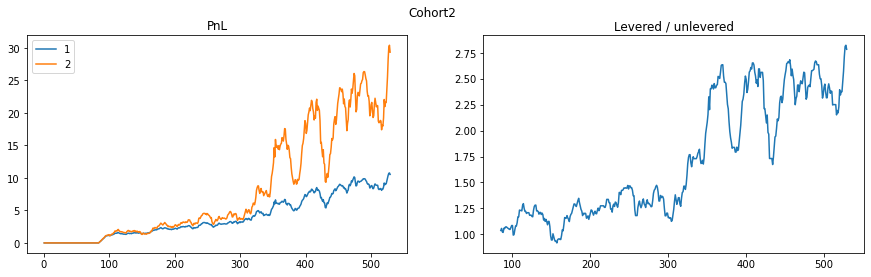

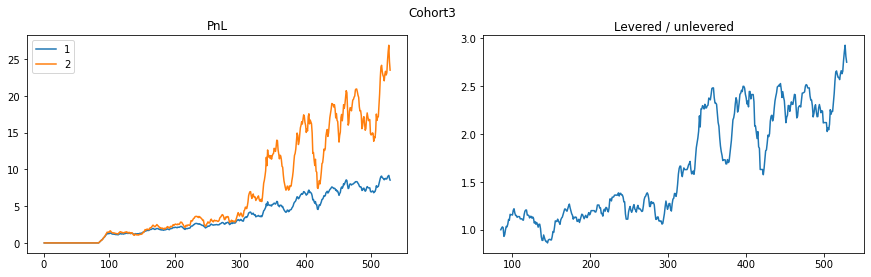

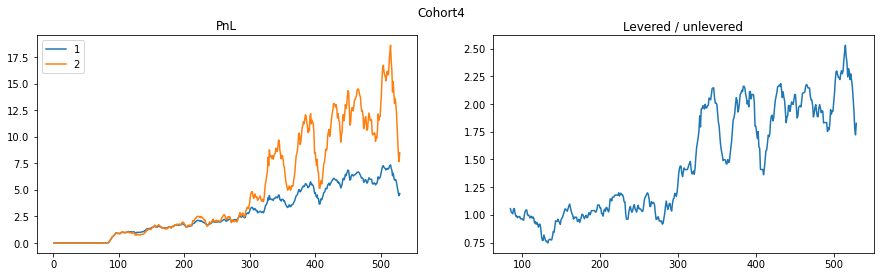

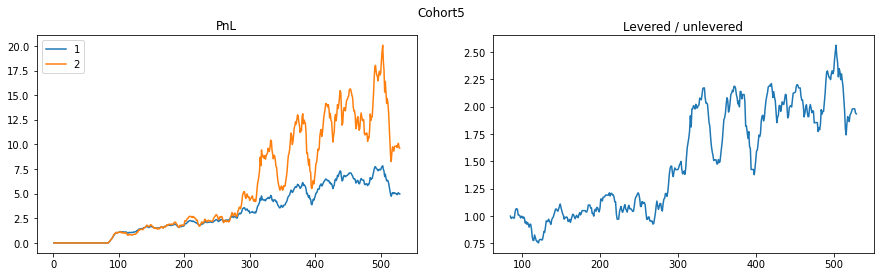

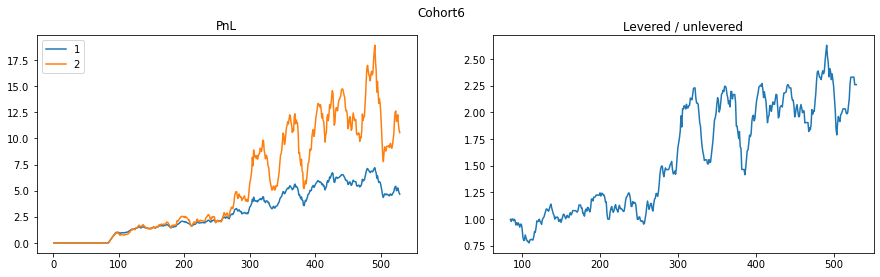

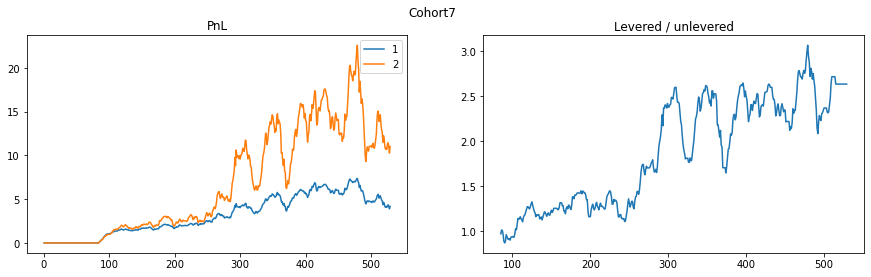

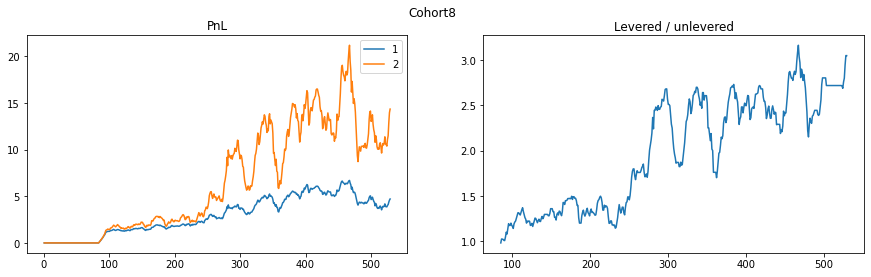

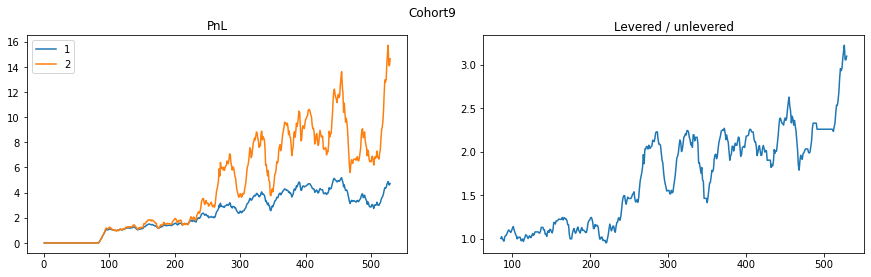

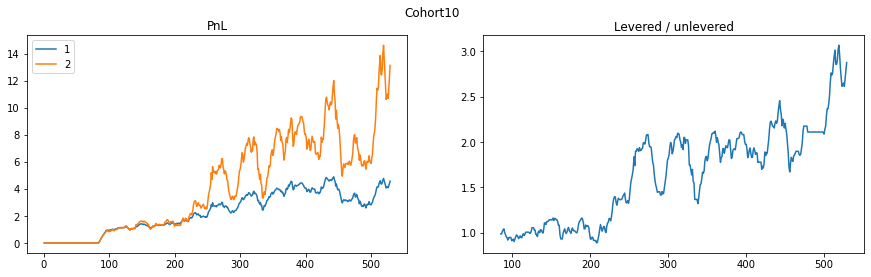

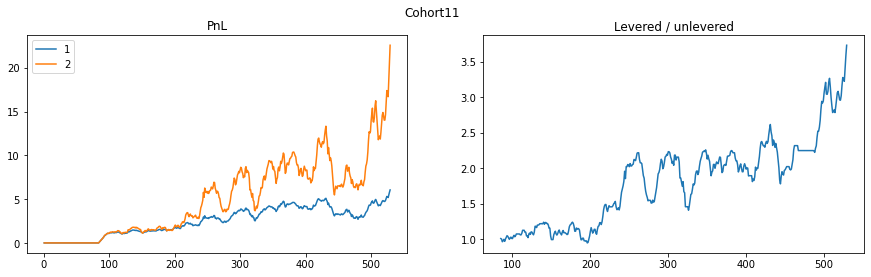

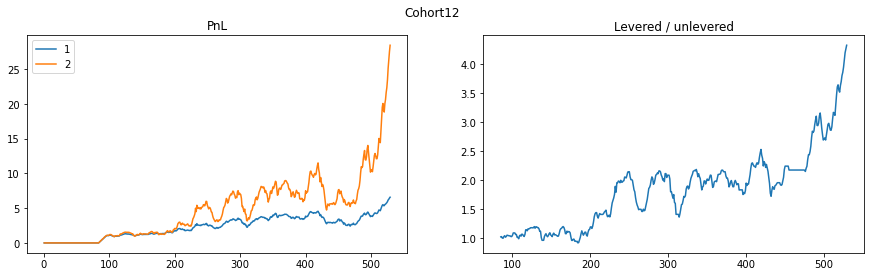

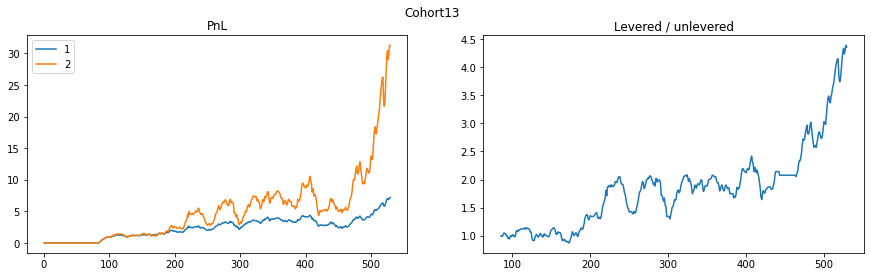

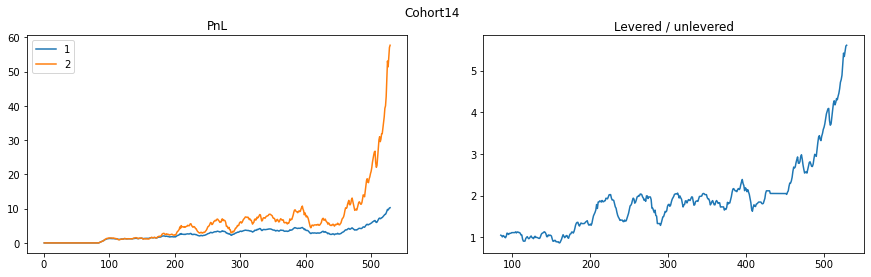

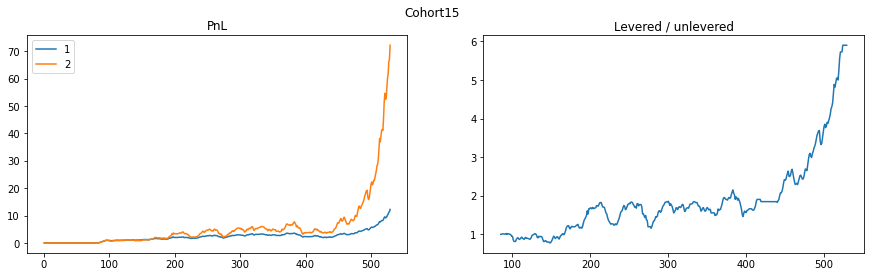

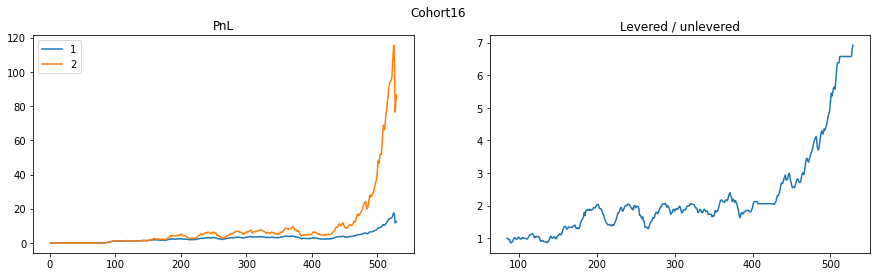

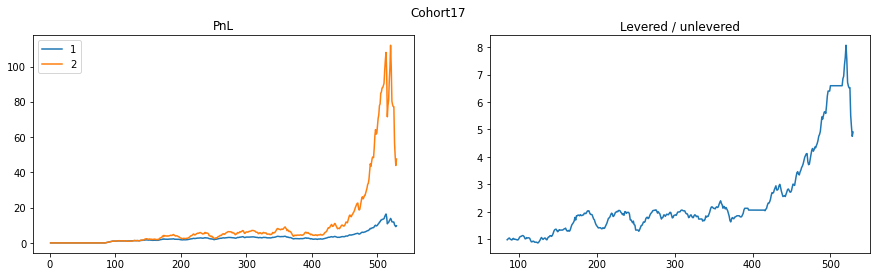

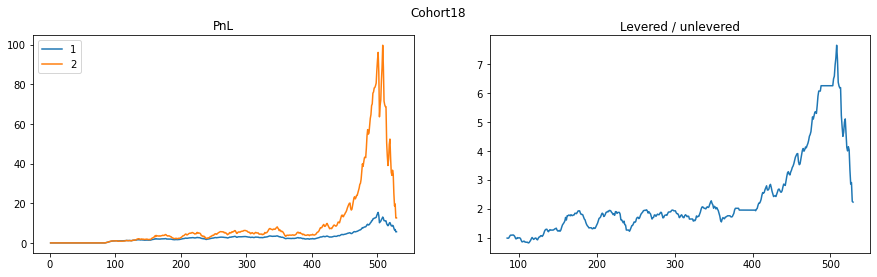

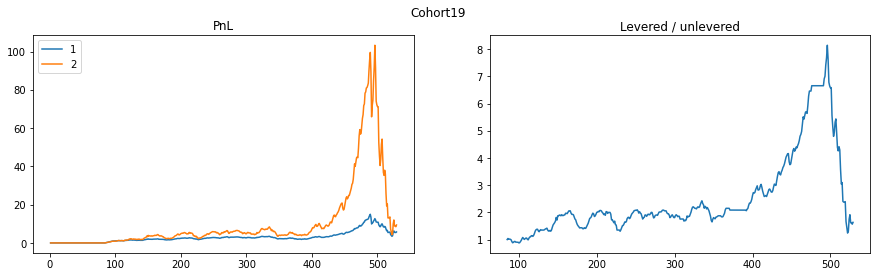

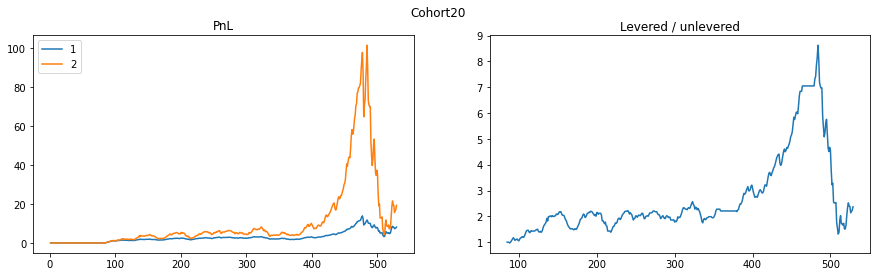

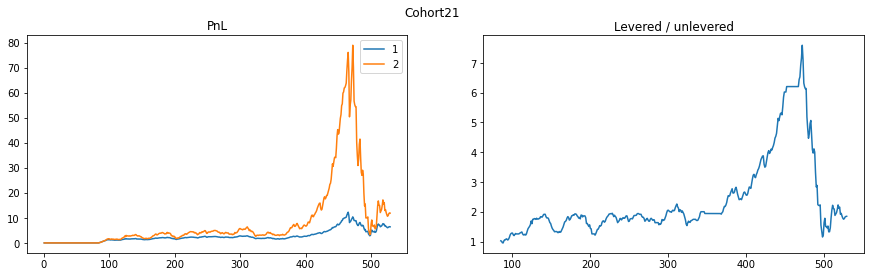

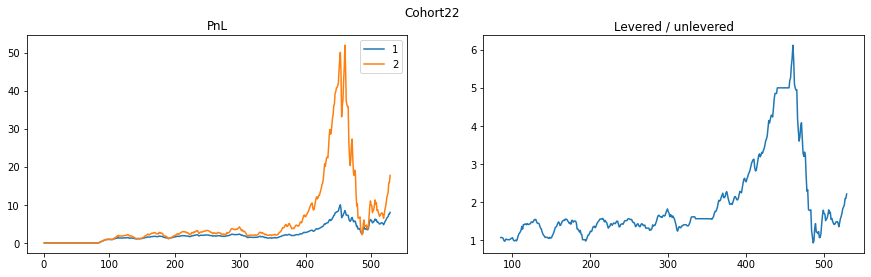

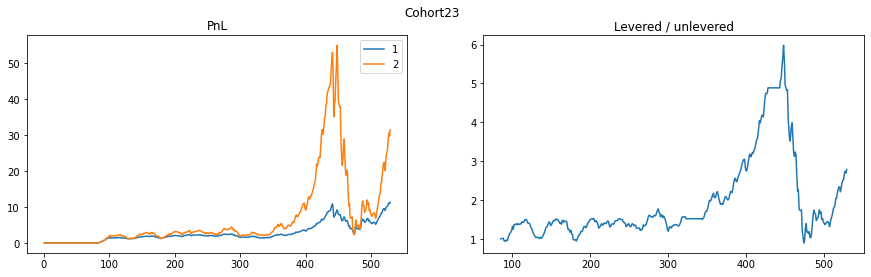

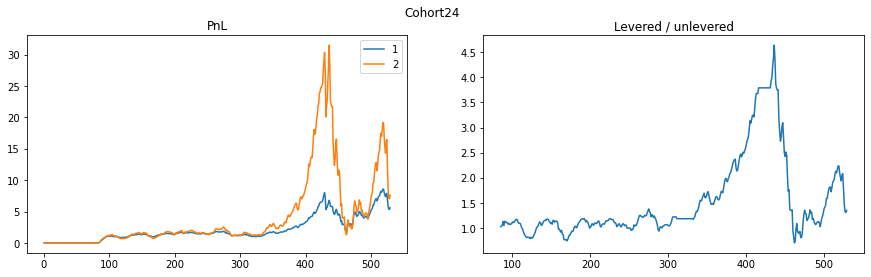

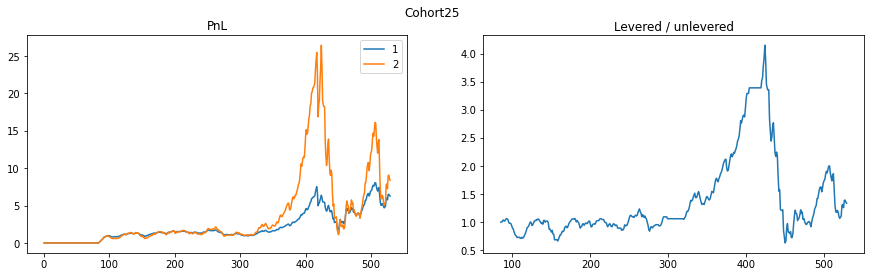

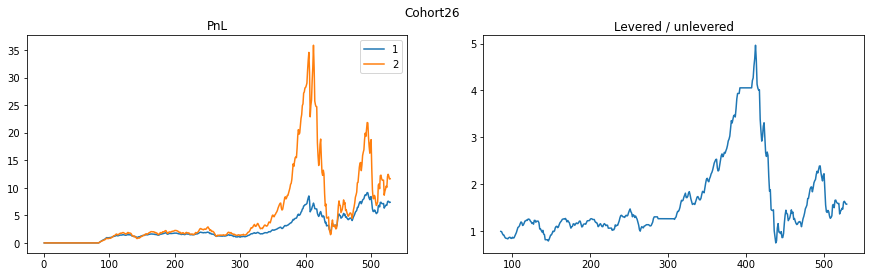

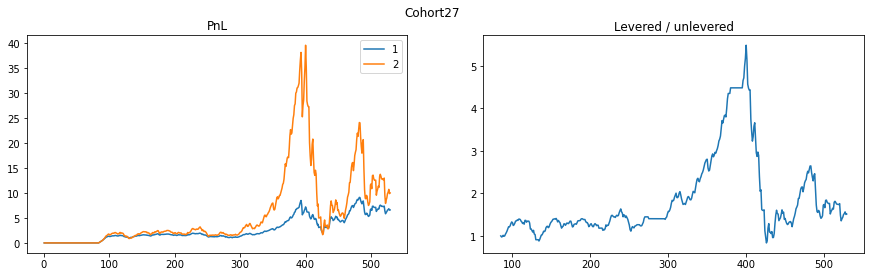

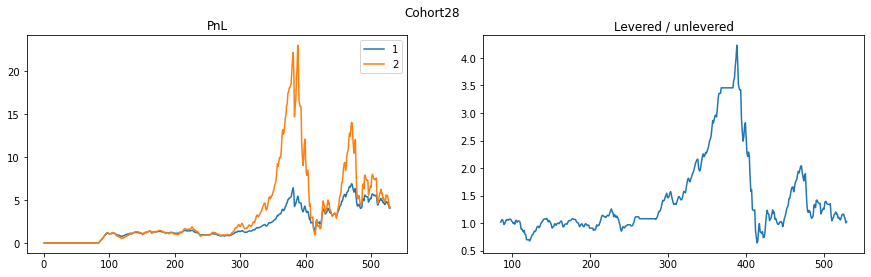

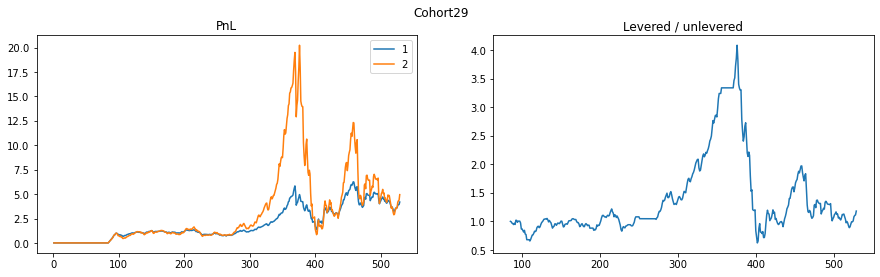

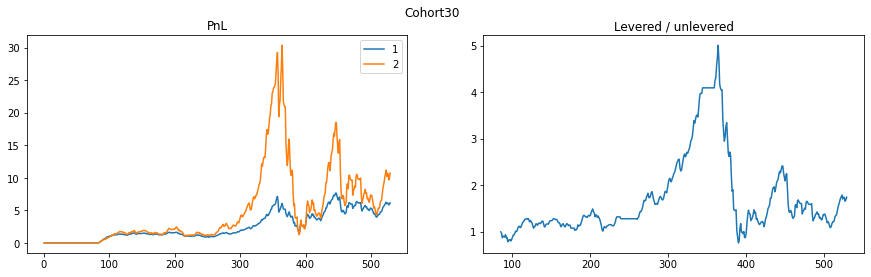

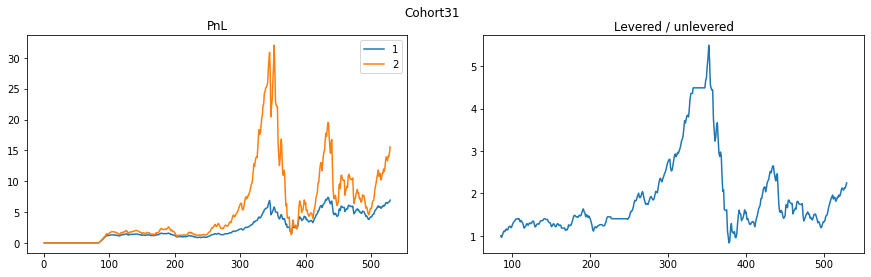

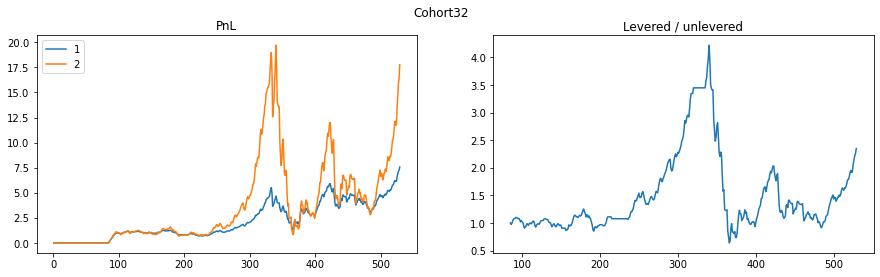

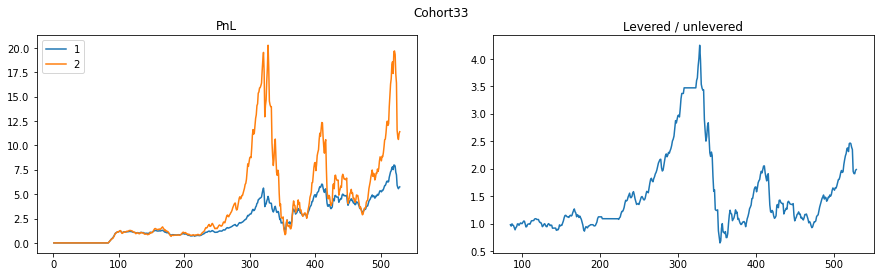

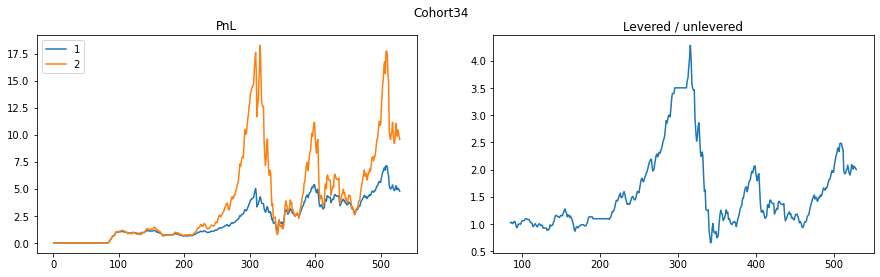

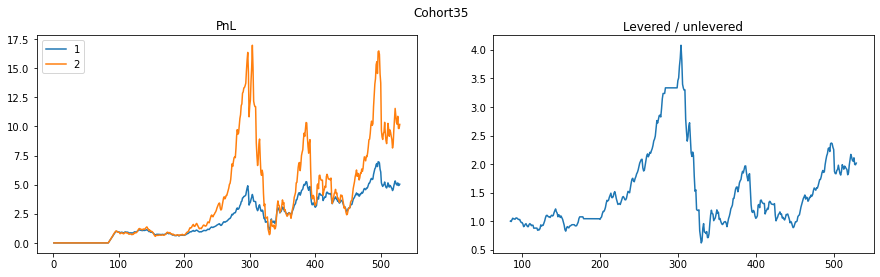

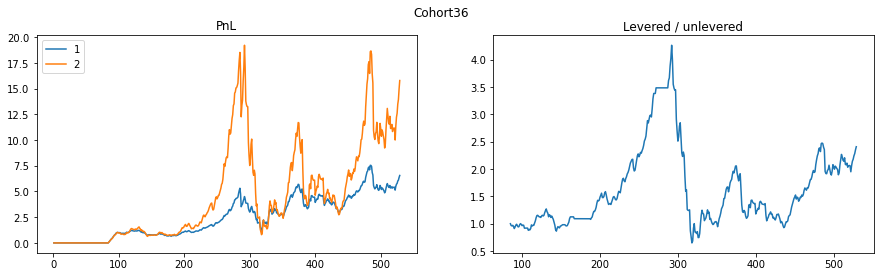

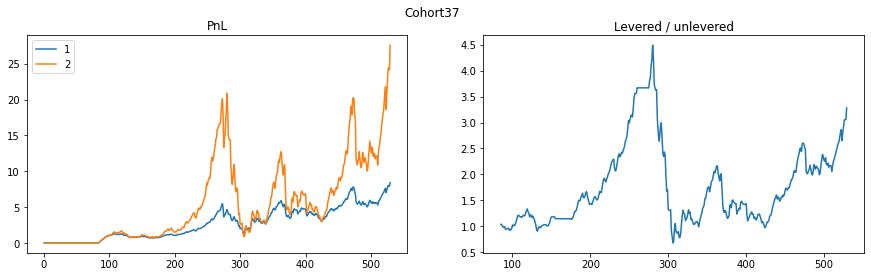

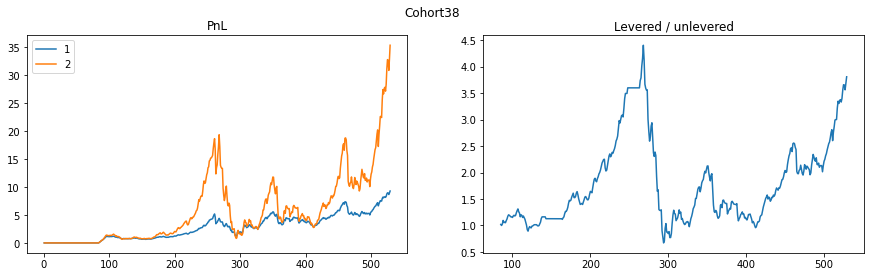

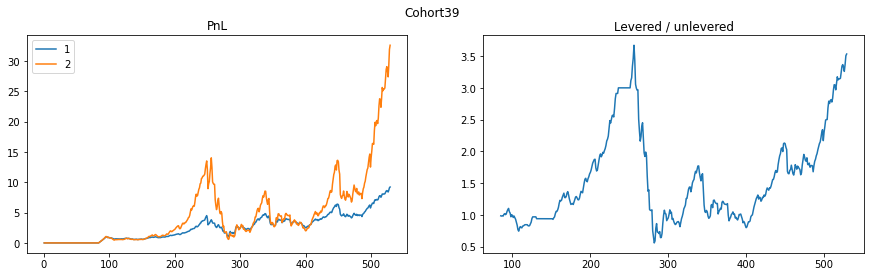

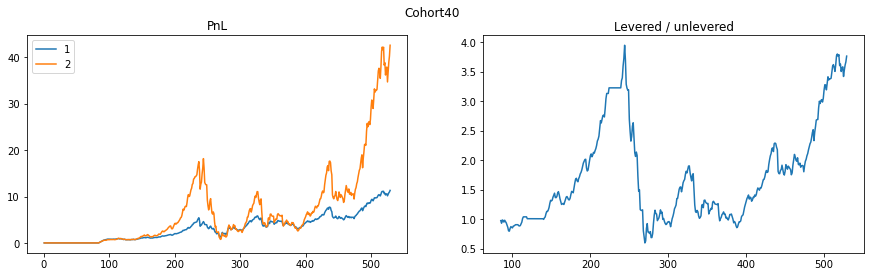

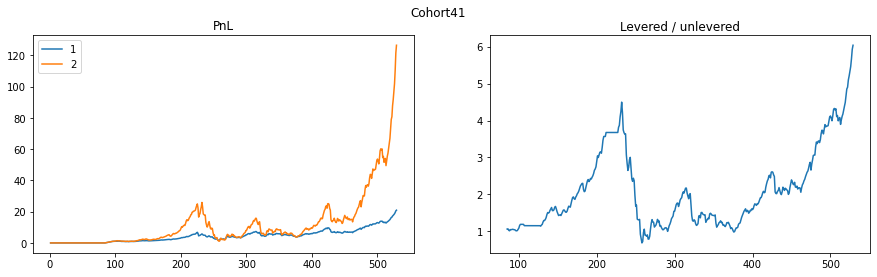

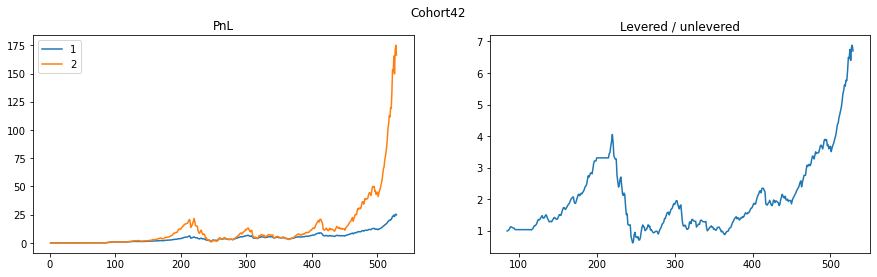

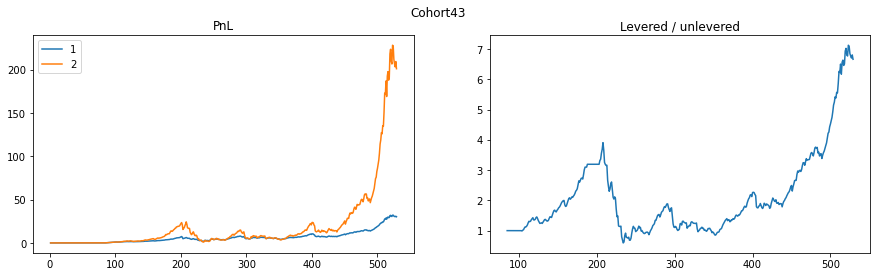

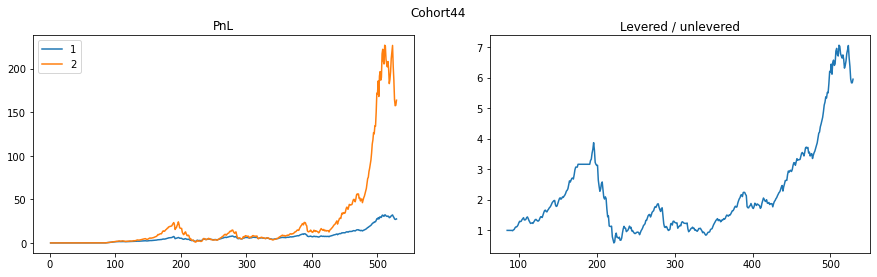

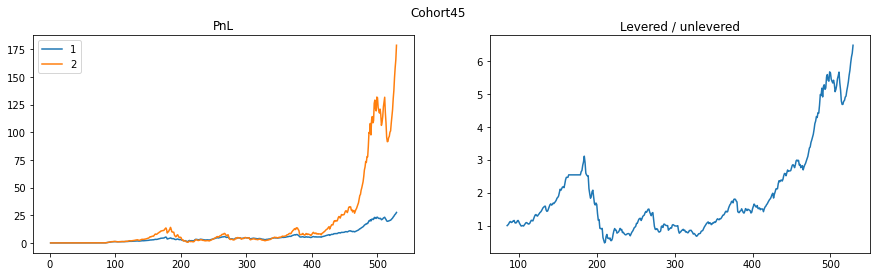

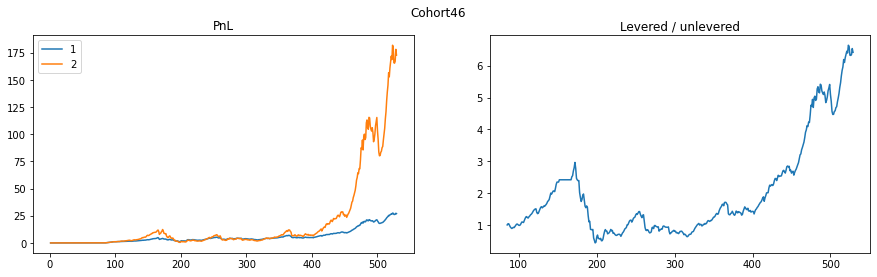

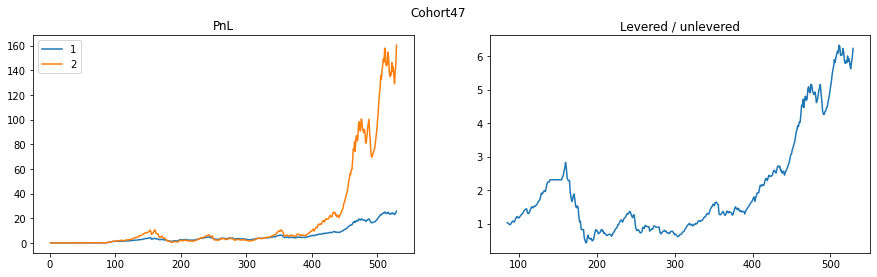

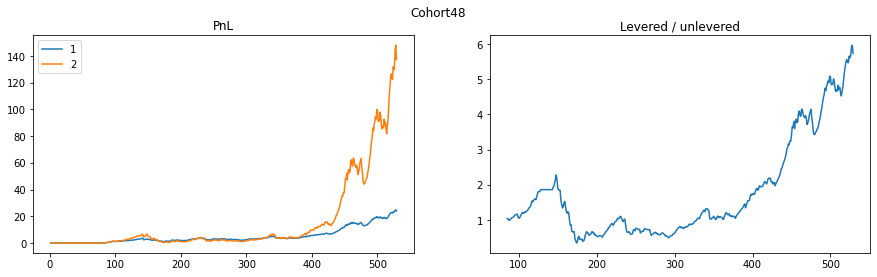

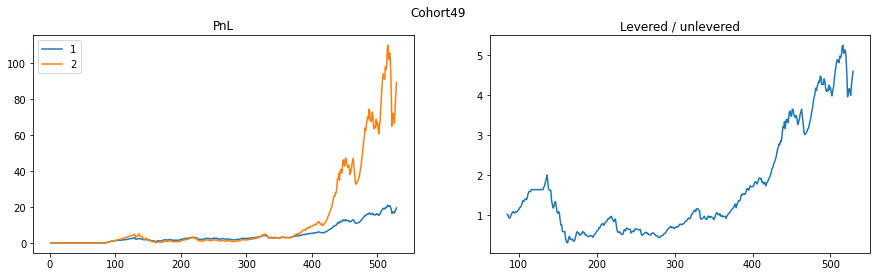

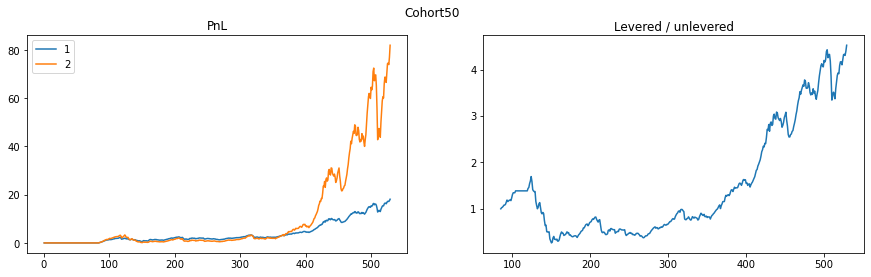

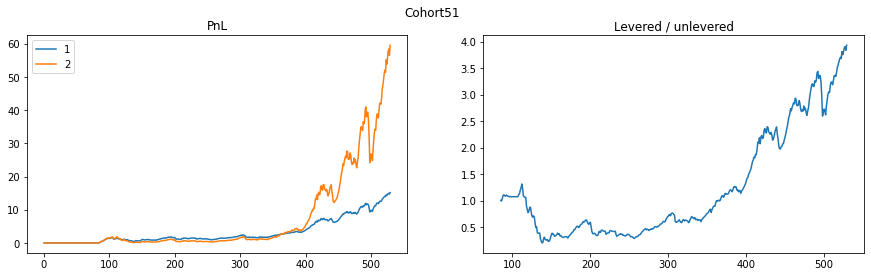

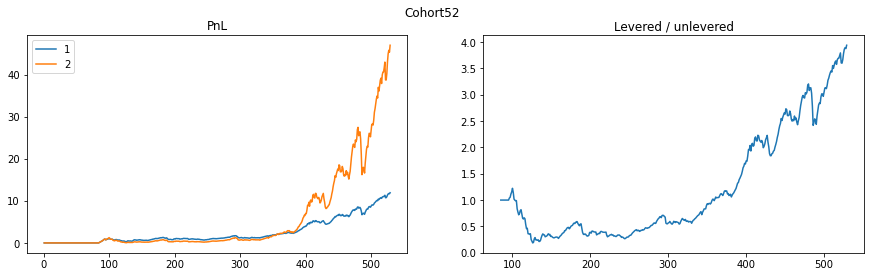

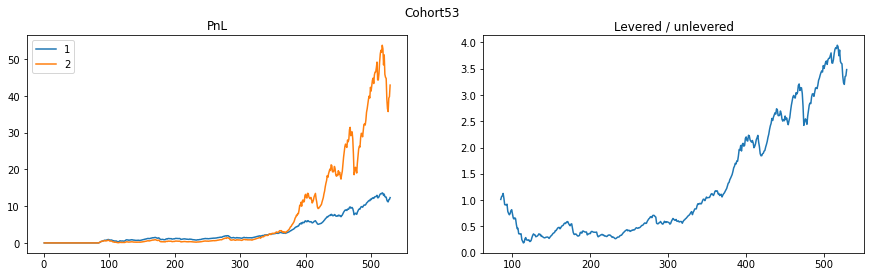

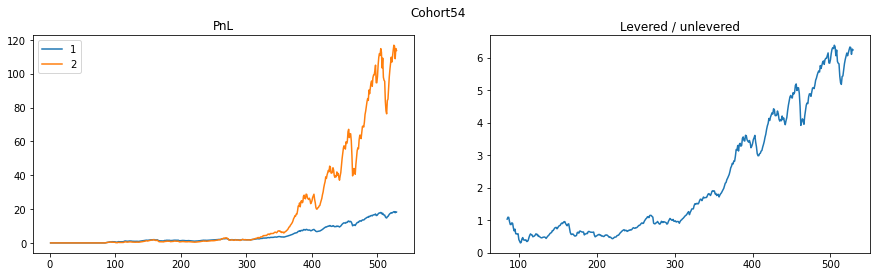

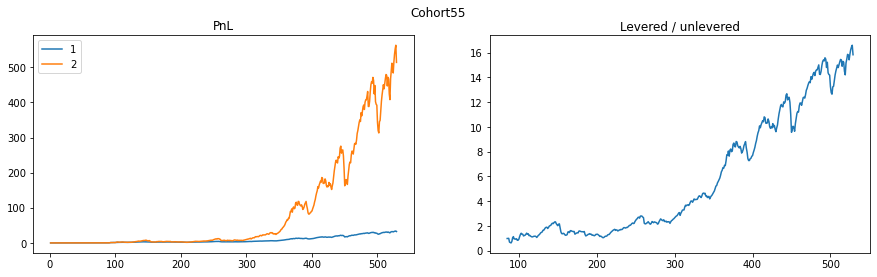

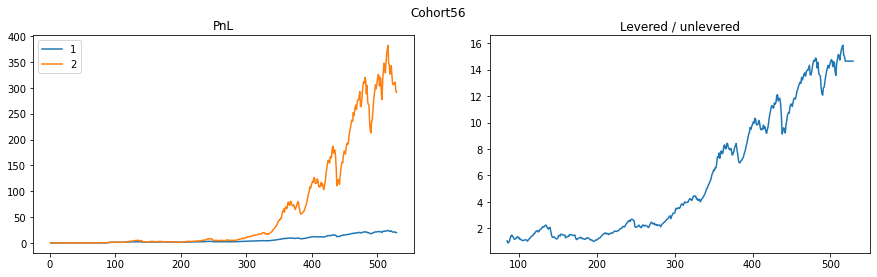

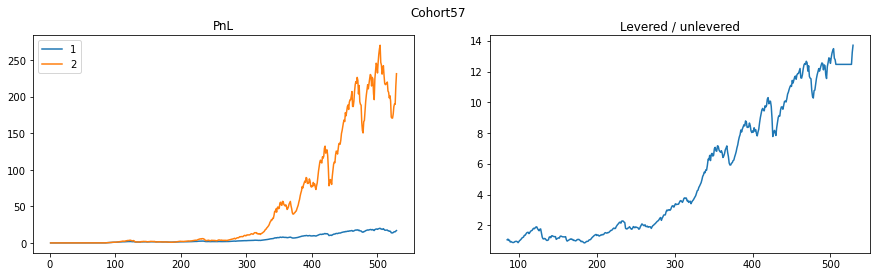

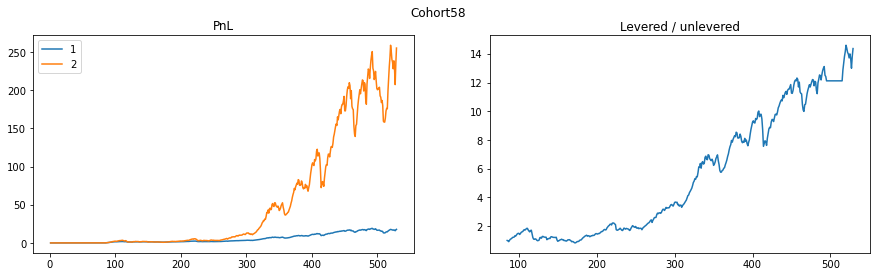

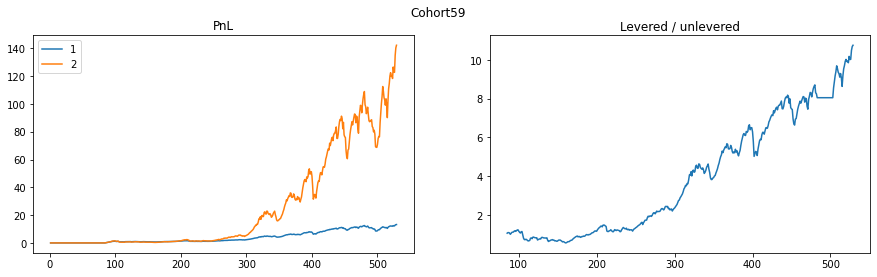

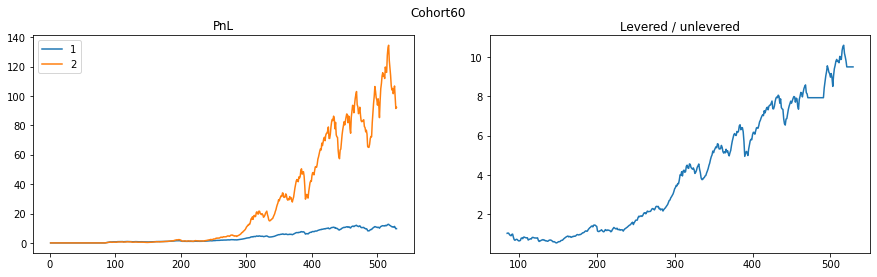

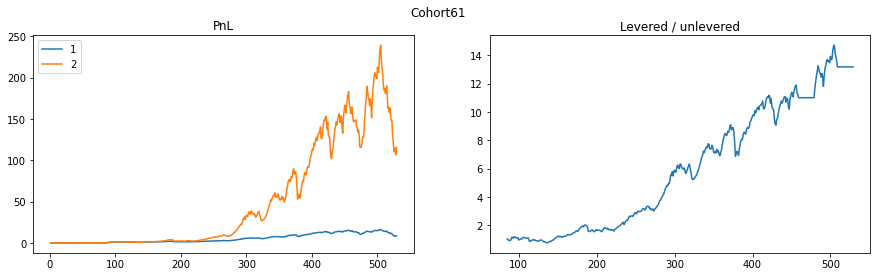

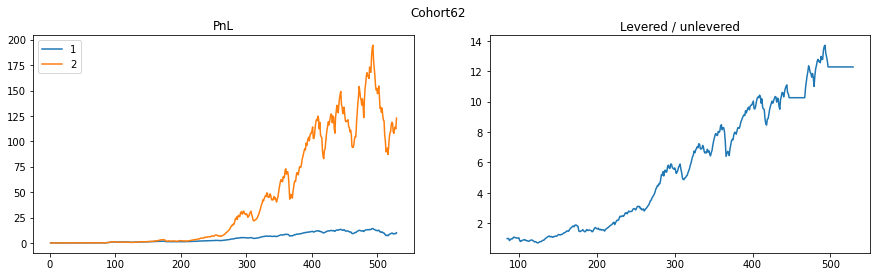

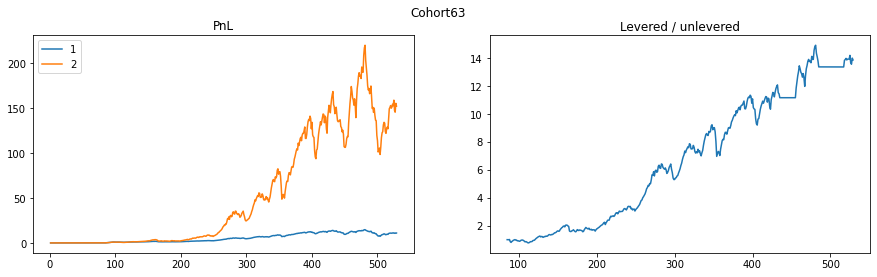

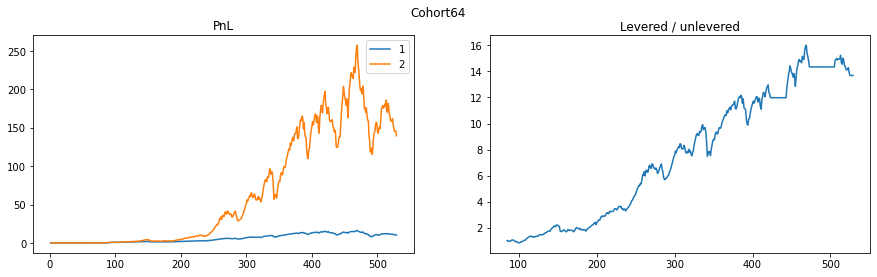

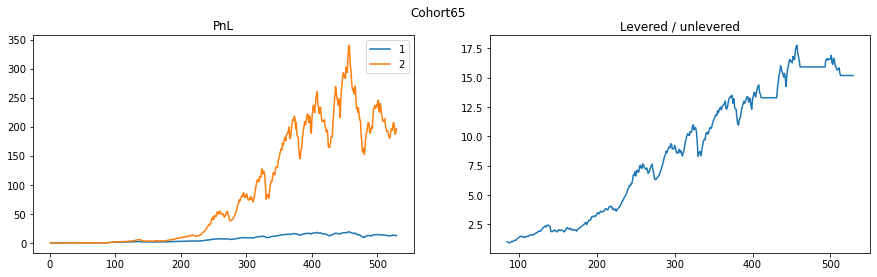

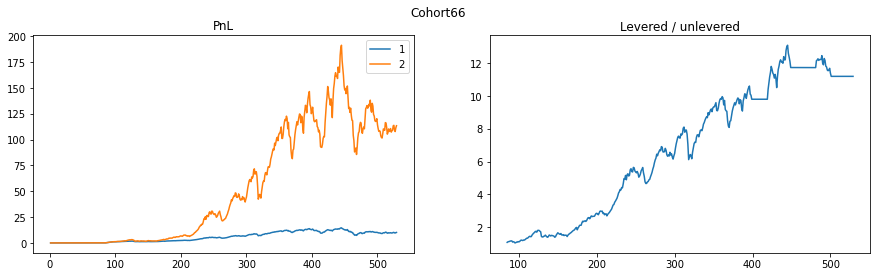

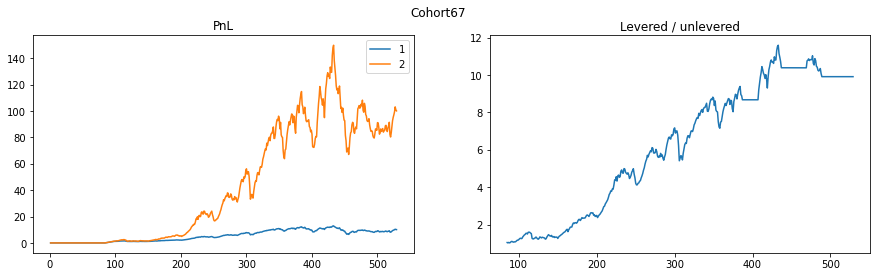

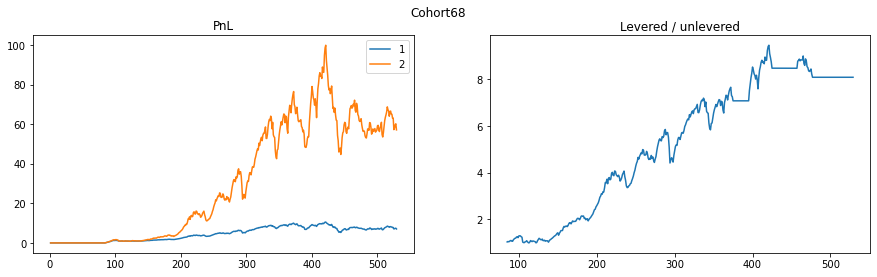

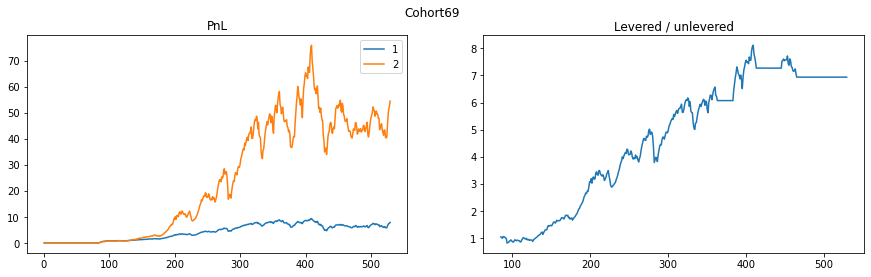

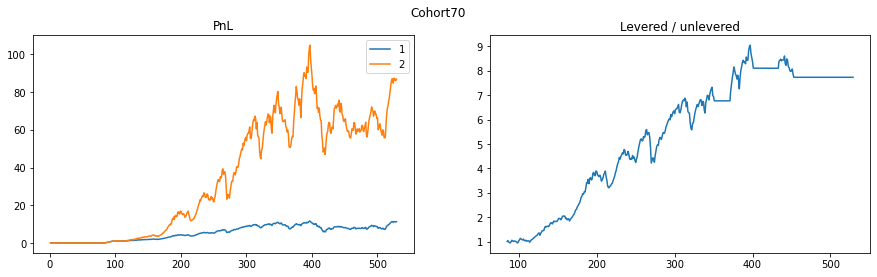

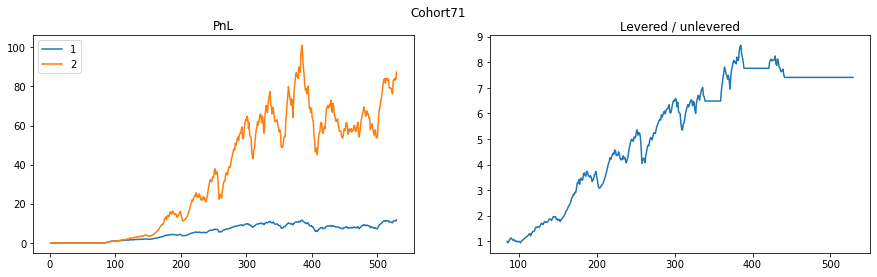

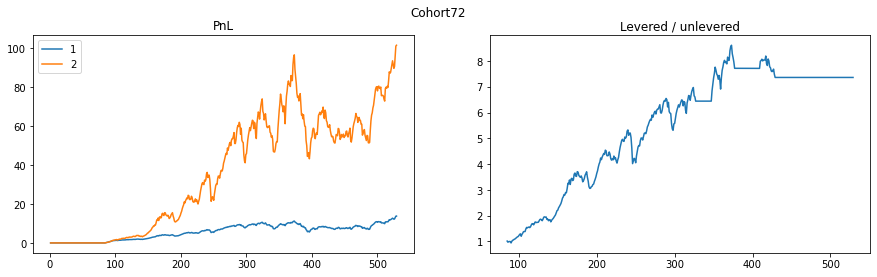

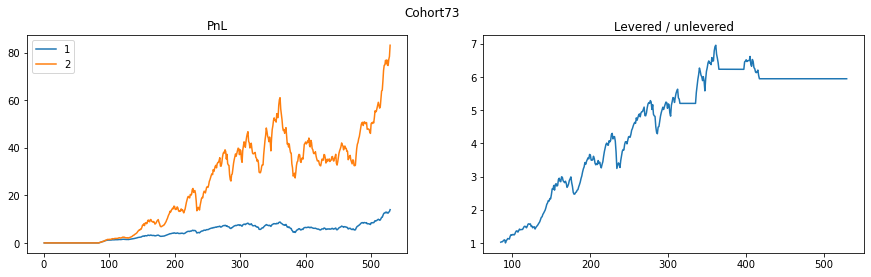

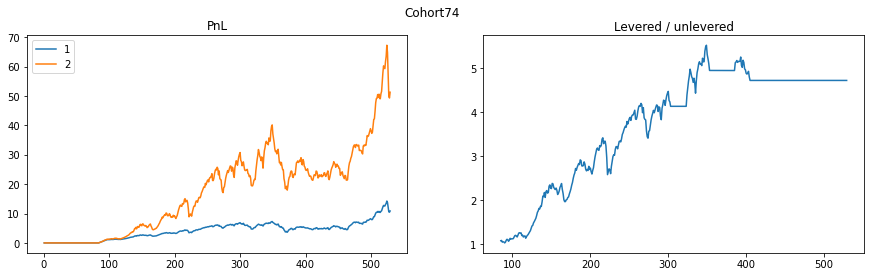

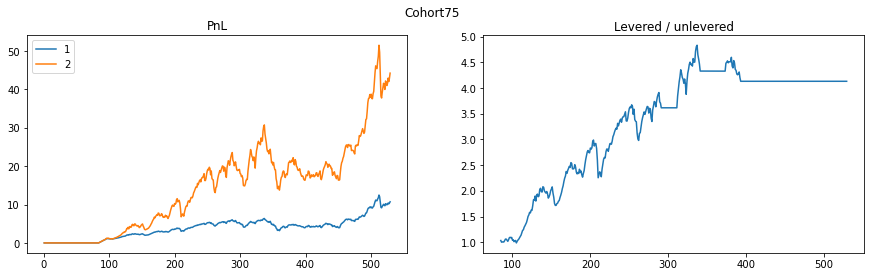

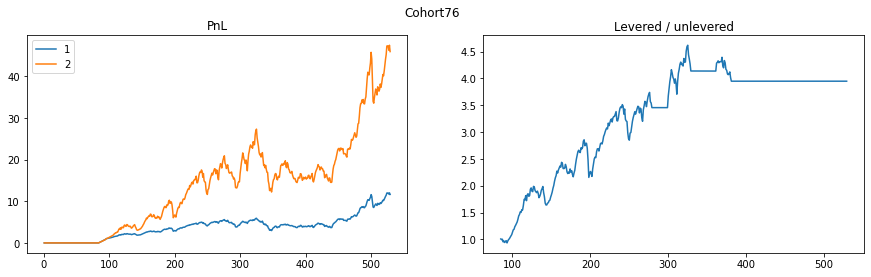

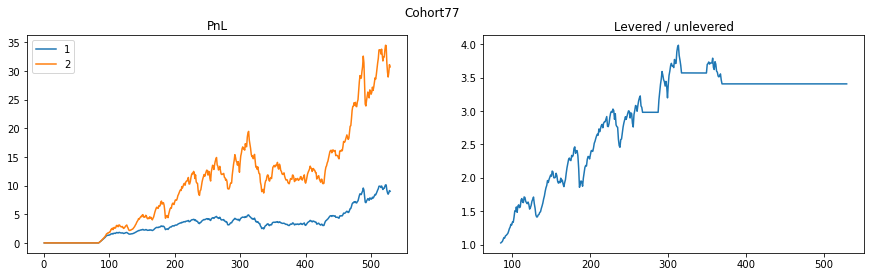

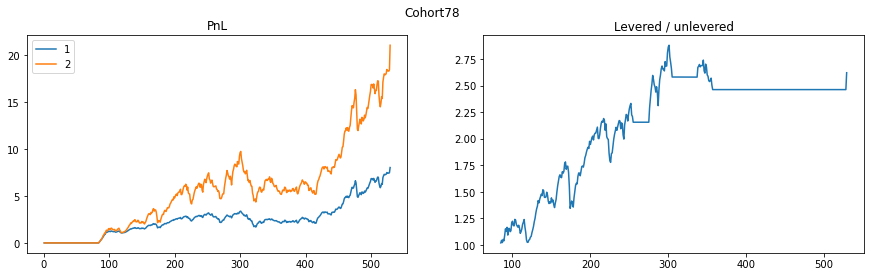

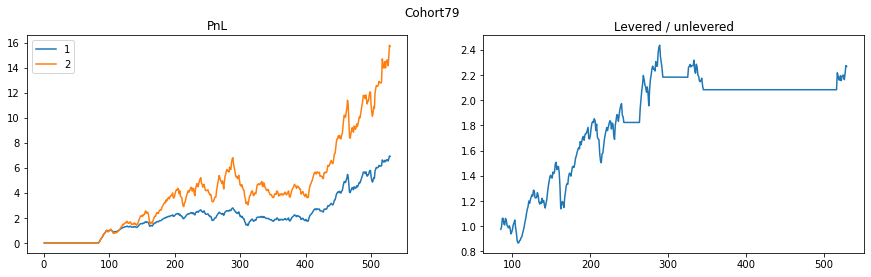

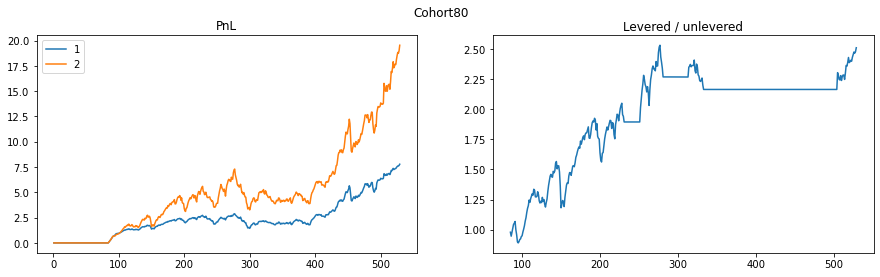

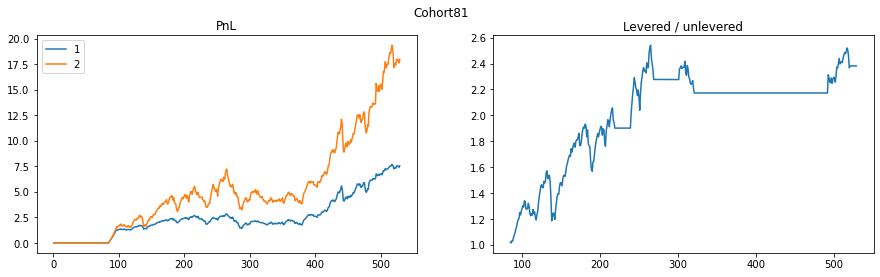

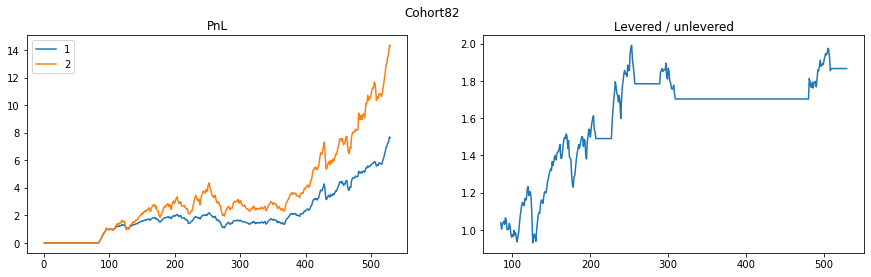

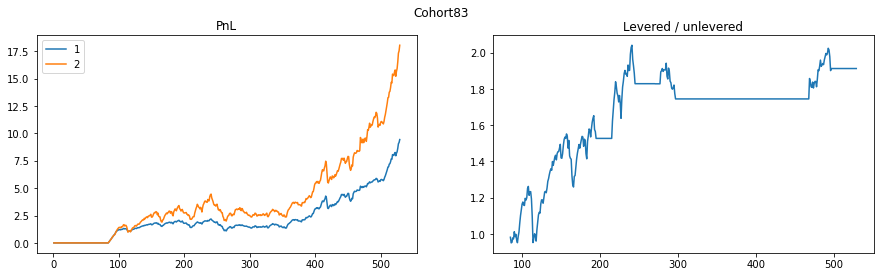

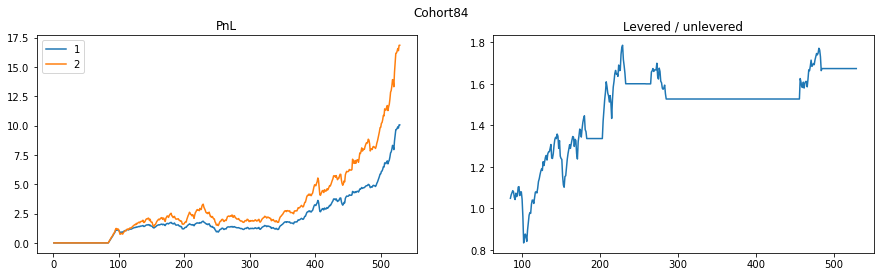

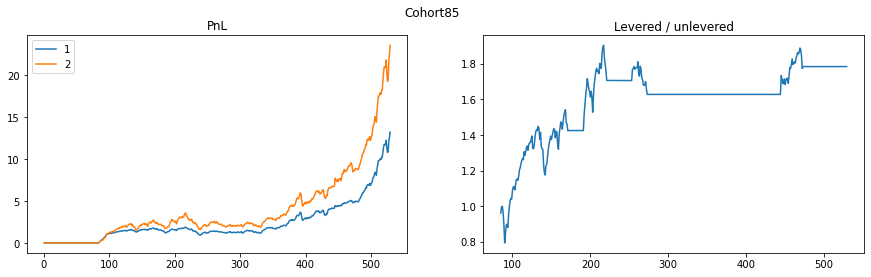

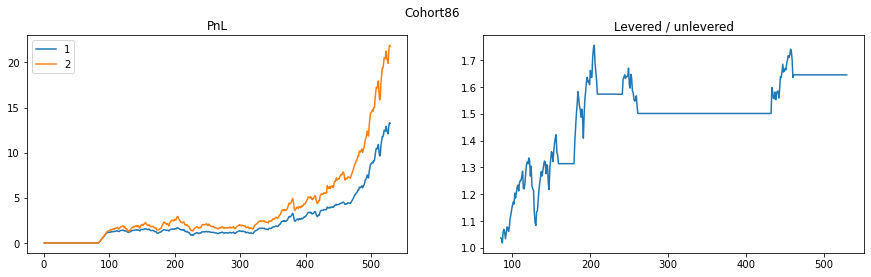

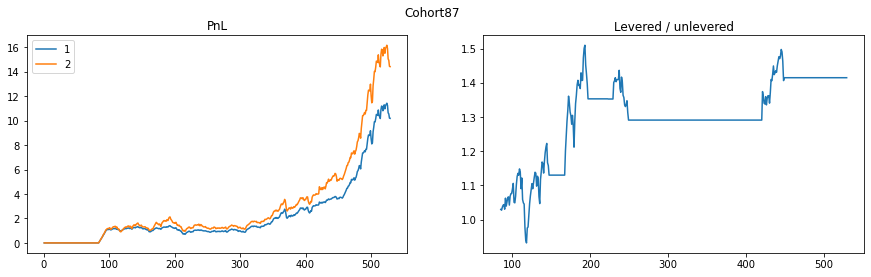

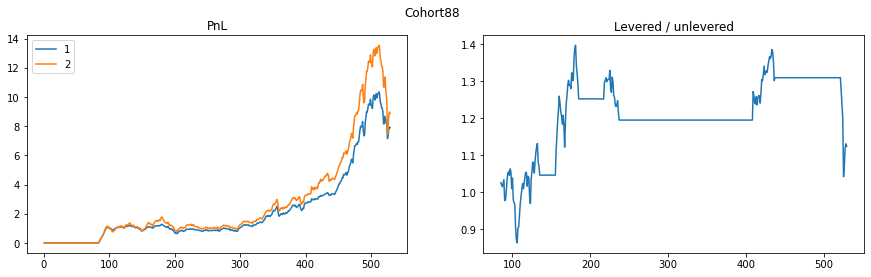

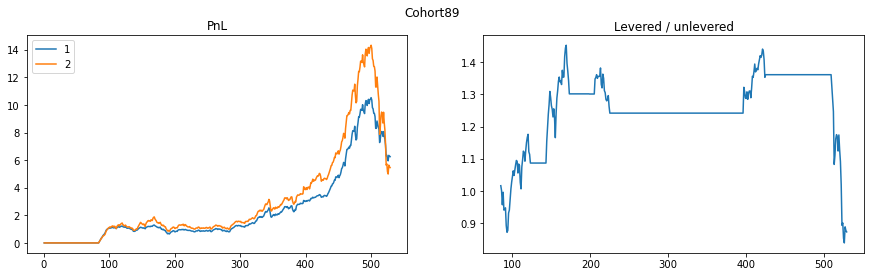

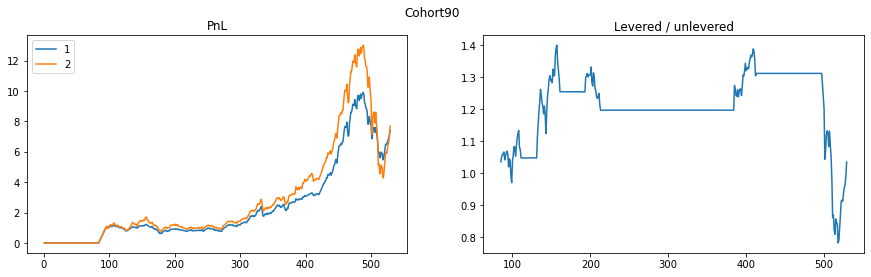

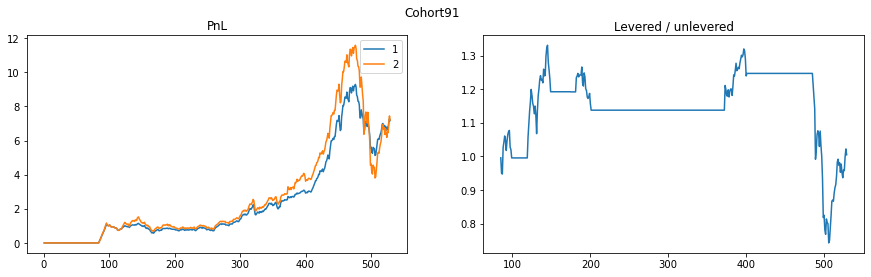

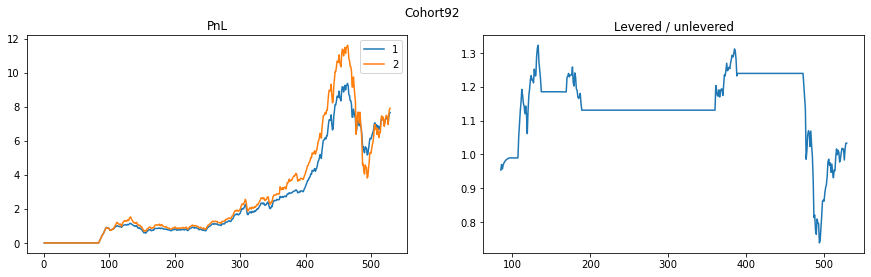

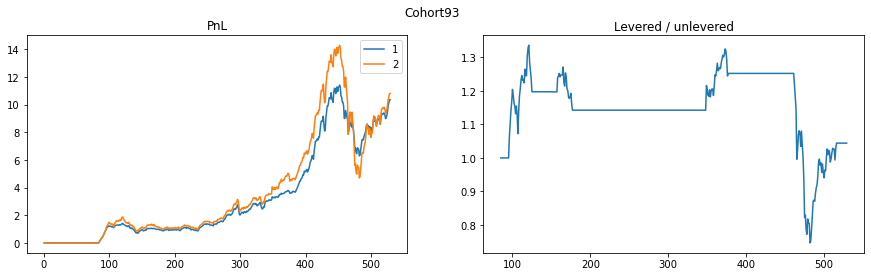

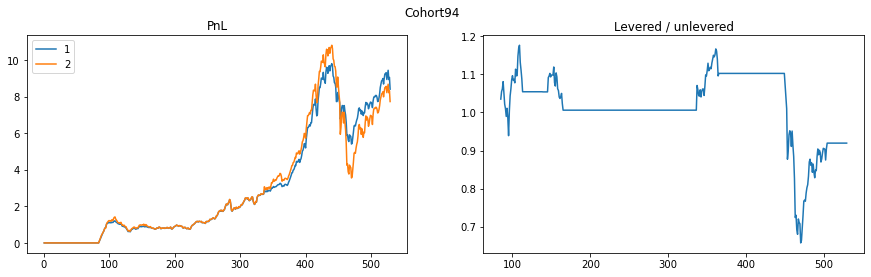

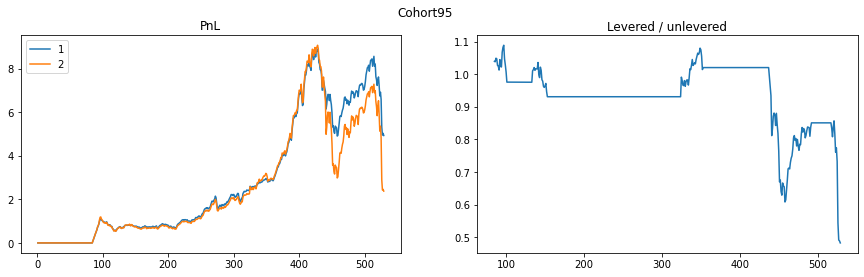

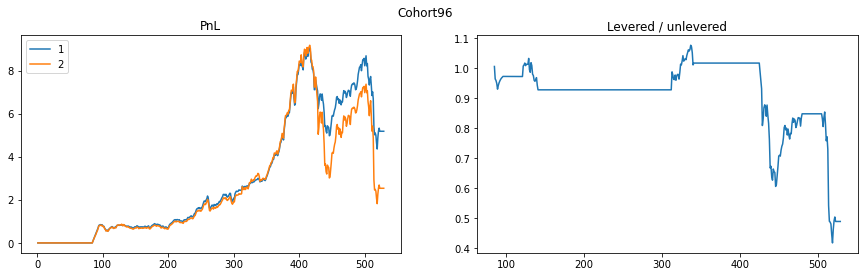

In [21]:
for cohort in df3.cohort_num.unique()[0:]:#[1,90]:
    compare_strategies(df3, cohort)

In [5]:
# these percentiles are not for matching runs, so they're misleading
df3.loc[(df3.period_num==529), :].groupby('lambdacons')['value']. \
    describe(percentiles=[0.02, 0.04, 0.06, 0.08, 0.1, 0.2, 0.3, 0.4])

,count,mean,std,min,2%,4%,6%,8%,10%,20%,30%,40%,50%,max
lambdacons,,,,,,,,,,,,,,
1,96.0,10.838755,6.290406,4.069389,4.187014,4.631923,4.697269,4.762117,4.950491,6.255027,7.175316,7.894735,9.250596,32.458502
2,96.0,62.308651,78.925883,2.379273,4.036824,5.357489,7.464126,7.717549,8.148067,10.739274,14.377922,18.057393,28.015666,513.942705


In [12]:
# pivot to take the multiple of the levered to unlevered strategy
df4 = df3.pivot(index=['cohort_num', 'period_num'], columns=['lambdacons'], values=None)

df4.columns = df4.columns.droplevel(0)
df4.columns.name = None

df4.loc[:, 'diff'] = df4.loc[:, 2] / df4.loc[:, 1]

In [13]:
# On any random day, levering works 88% of the time!
df4['diff'].describe([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.12, 0.13, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

count    42720.000000
mean         2.574583
std          2.535445
min          0.186174
1%           0.429515
2%           0.569669
3%           0.676509
4%           0.767537
5%           0.825421
6%           0.871973
7%           0.908635
8%           0.928140
9%           0.940776
10%          0.960804
12%          0.992123
13%          1.004537
15%          1.022632
20%          1.089248
30%          1.227353
40%          1.399354
50%          1.664292
60%          1.943744
70%          2.283310
80%          3.343490
90%          5.944154
max         17.752963
Name: diff, dtype: float64

In [14]:
df4.head()

1    2  diff
cohort_num period_num                
1          1           0.0  0.0   NaN
           2           0.0  0.0   NaN
           3           0.0  0.0   NaN
           4           0.0  0.0   NaN
           5           0.0  0.0   NaN

In [21]:
# For final portfolios, levering works 95%+ of the time!
df5 = df4.reset_index()

df5.loc[(df5['period_num']==529),'diff'].describe([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.12, 0.13, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

count    96.000000
mean      4.630498
std       3.867324
min       0.482330
1%        0.489061
2%        0.834677
3%        0.912492
4%        0.987856
5%        1.025939
6%        1.033345
7%        1.034678
8%        1.040646
9%        1.087929
10%       1.152180
12%       1.343703
13%       1.373932
15%       1.531351
20%       1.743803
30%       2.115210
40%       2.488282
50%       3.188065
60%       3.947397
70%       5.818833
80%       6.699202
90%      10.983031
max      15.833839
Name: diff, dtype: float64